In [16]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt


In [2]:
df0 = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13764723 entries, 0 to 13764722
Data columns (total 14 columns):
Unnamed: 0             int64
FL_DATE                datetime64[ns]
OP_UNIQUE_CARRIER      object
ORIGIN_AIRPORT_ID      int64
DEST_AIRPORT_ID        int64
DEP_DELAY              float64
AIR_TIME               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
FRAC_YEAR              float64
FRAC_DAY               float64
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.4+ GB


In [3]:
df0 = df0[~df0["FL_DATE"].dt.year.isin([2020,2021,2023])] # excise pandemic
delay_thresh=15.

df0=df0.assign(DELAY_TF=pd.Series(df0['DEP_DELAY']>delay_thresh).values.astype(float)) # declare delay TRUE/FALSE 

df = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot
X = df.drop(columns=['FL_DATE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY','DELAY_TF'])
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
X = X.apply(pd.to_numeric)
X = X.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_YEAR']/1.0)).values)
X = X.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_YEAR']/1.0)).values)
X = X.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_DAY']/1.0)).values)
X = X.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_DAY']/1.0)).values)
X = X.drop(columns=['FRAC_DAY','FRAC_YEAR'])
y = df['DELAY_TF']

In [4]:
X.head()

,AIR_TIME,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,ORIGIN_AIRPORT_ID_10721,ORIGIN_AIRPORT_ID_11057,...,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,DEST_AIRPORT_ID_14869,YEAR_FRAC_sin,YEAR_FRAC_cos,DAY_FRAC_sin,DAY_FRAC_cos
0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005293,0.999986,0.933580,-0.358368
1,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006330,0.999980,0.734323,-0.678801
2,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007403,0.999973,0.418660,-0.908143
3,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007856,0.999969,0.263031,-0.964787
4,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008774,0.999962,-0.069756,-0.997564


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,random_state=41,test_size=.2,stratify=y)

In [10]:
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# LOGISTIC REGRESSION
log_reg = LogisticRegression(class_weight = 'balanced') #,penalty='l1',solver='liblinear')
mod=log_reg.fit(X_train, y_train)
y_predict=mod.predict_proba(X_test)

# analyze fit
cm=confusion_matrix(y_test, y_predict[:,1] >= 0.5)
print(cm/float(len(y_test)))
print(classification_report(y_test,y_predict[:,1] >= 0.5))

[[0.46610064 0.34188792]
 [0.07422953 0.11778191]]
              precision    recall  f1-score   support

         0.0       0.86      0.58      0.69   1780242
         1.0       0.26      0.61      0.36    423059

    accuracy                           0.58   2203301
   macro avg       0.56      0.60      0.53   2203301
weighted avg       0.75      0.58      0.63   2203301



[[0.77189771 0.03609085]
 [0.11167471 0.08033673]]
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91   1780242
         1.0       0.69      0.42      0.52    423059

    accuracy                           0.85   2203301
   macro avg       0.78      0.69      0.72   2203301
weighted avg       0.84      0.85      0.84   2203301



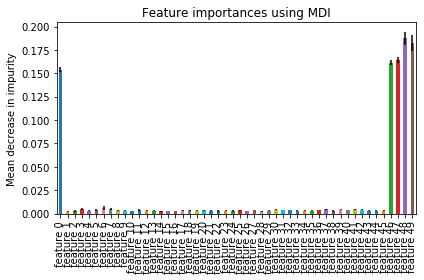

In [12]:
# RANDOM FOREST
model = RandomForestClassifier(n_estimators=15) # class_weight='balanced', n=30 only a few % better than n=4
clf = model.fit(X_train, y_train)
y_predict=clf.predict(X_test)

# analyze fit
cm=confusion_matrix(y_test, y_predict >= 0.5)
print(cm/float(len(y_test)))
print(classification_report(y_test,y_predict >= 0.5))

# feature importance based on impurity
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


In [ ]:
# based on permutation
model_fi = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
forest_importances = pd.Series(model_fi.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=model_fi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [18]:
# XG BOOST
model = xgb.XGBClassifier(objective="binary:logistic",n_estimators=15)
clf = model.fit(X_train, y_train)
y_predict=clf.predict(X_test)
cm=confusion_matrix(y_test, y_predict >= 0.5)
print(cm/float(len(y_test)))
print(classification_report(y_test,y_predict >= 0.5))

[[0.80714982 0.00083874]
 [0.18755404 0.0044574 ]]
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90   1780242
         1.0       0.84      0.02      0.05    423059

    accuracy                           0.81   2203301
   macro avg       0.83      0.51      0.47   2203301
weighted avg       0.82      0.81      0.73   2203301

